# Lab07 - Rezolvarea unor probleme de clasificare prin metode de învățare automată
### Obiective
Dezvoltarea sistemelor care învaţă singure. Probleme de tip clasificare rezolvate cu ajutorul rețeleleor neuronale artificiale (Artificial Neural Networks - ANN). Evaluareaa performanței acestor metode.

### Aspecte teoretice
Rețele neuronale artificiale pentru rezolvarea problemelor de clasificare.
Proiectarea sistemelor care învaţă singure.
Evaluarea sistemelor care învaţă singure. Metrici de performanță.

### Probleme
**Retea sociala: ce fel de poze ai postat?** (TEMA) Tocmai ti-ai inceput prima ta zi de munca ca si software developer la Facebook in echipa care se ocupa cu partea de continut a platformei. Echipa de analisti a observat ca foarte multe persoane folosesc filtre peste pozele lor, asadar in speranta de a promova continut mai putin editat, si poze cat mai reale, doresc sa implementeze o noua functionalite in care sa arate utilizatorilor daca o poza a fost sau nu editata. Pentru a testa aceasta idee, si pentru a vedea daca utlizatorilor li s-ar parea folositoare o astfel de functionalitate, au decis sa testeze ideea pe pozele care au filtre sepia. Primul task al tau este sa implementezi un algoritm de clasificare a pozelor care sa ne spuna daca o poza are sau nu adaugat filtru sepia. Team leaderul echipei de ML iti propune urmatorul plan de lucru:
1. devoltarea, antrenarea si testarea unui clasificator bazat pe retele neuronale folosind date mai simple, de tip caracteristici numerice - de ex datele cu irisi) - Lucky you! Go to DEMO!
2. devoltarea, antrenarea si testarea unui clasificator bazat pe retele neuronale folosind date mai complexe, de tip imagine - de ex baza de date cu cifre, pentru fiecare exemplu se va considera matricea de pixeli) - Lucky you! Go to DEMO!
3. crearea unei baze cu imagini (cu si fara filtru sepia) si etichetele corespunzatoare - Let’s get down to business!
4. antrenarea si testarea clasificatorului (bazat pe retele neuronale artificiale – tool sau ANN-ul dezvoltat) pentru clasificarea imaginilor cu si fara filtru - It's time to hustle!

### Cerinte
Specificaţi, proiectaţi, implementaţi si testati cate un algoritm de clasificare bazat pe retele neuronale artificiale (ANN sau CNN). Verificati influenta (hyper)parametrilor asupra calitatii clasificatorului antrenat.

### Evaluarea
Punctajele acordate:

- creare baza de date - 50p
- antrenarea unui model si testarea lui pentru clasificarea imaginilor normale vs sepia
    - cu ANN (tool) - 50p
    - influenta (hyper)parametrilor - 100p
    - cu ANN (cod propriu) - 300p
    - cu CNN (cod propriu) - 300p

## 1. Create image database

In [1]:
import random

from PIL import Image
import numpy as np
import os

from sklearn.preprocessing import StandardScaler

In [2]:
# functie de aplicare filtru sepia

def apply_sepia(image: Image.Image):
    image = image.convert("RGB")
    pixels = image.load()

    for x in range(image.height):
        for y in range(image.width):
            r, g, b = pixels[x, y]

            # se converteste fiecare canal de culoare pentru fiecare pixel la sepia
            tr = int(0.393 * r + 0.769 * g + 0.189 * b)
            tg = int(0.349 * r + 0.686 * g + 0.168 * b)
            tb = int(0.272 * r + 0.534 * g + 0.131 * b)

            # se normalizeaza valorile obtinute pentru a fi valide
            pixels[x, y] = (
                min(255, tr),
                min(255, tg),
                min(255, tb)
            )

    return image

In [3]:
from PIL import Image, ImageDraw

# functie pentru desenare forme aleatorii peste o imagine
def draw_random_shapes(image):
    draw = ImageDraw.Draw(image)
    for _ in range(random.randint(5, 10)):
        shape_type = random.choice(["rectangle", "ellipse", "line"])
        x1, y1 = random.randint(0, 48), random.randint(0, 48)
        x2, y2 = x1 + random.randint(8, 16), y1 + random.randint(8, 16)
        color = tuple(random.randint(0, 255) for _ in range(3))
        if shape_type == "rectangle":
            draw.rectangle([x1, y1, x2, y2], fill=color)
        elif shape_type == "ellipse":
            draw.ellipse([x1, y1, x2, y2], fill=color)
        elif shape_type == "line":
            draw.line([x1, y1, x2, y2], fill=color, width=2)
    return image

# functie pentru generare dataset
def create_dataset(image_size: tuple[int, int], n: int):
    for i in range(n):
        base_color = tuple(random.randint(0, 255) for _ in range(3))
        # generare imagine
        img = Image.new("RGB", image_size, base_color)
        # desenare obiecte aleatorii
        img = draw_random_shapes(img)

        # salvare imagine normala
        img.save(f'dataset/normal/{i+1}.png')

        # aplicare filtru sepia si salvare imagine
        sepia_img = apply_sepia(img)
        sepia_img.save(f'dataset/sepia/{i+1}.png')

In [4]:
# cream baza de date cu imagini

create_dataset((64, 64), 500)

## 2. Load data

In [5]:
# functie de incarcare a datelor din baza de date

def load_data(normal_folder: str, sepia_folder: str):
    data = {}
    for filename in os.listdir(normal_folder):
        filepath = os.path.join(normal_folder, filename)
        data[filepath] = 0 # 0 semnifica imagine normala

    for filename in os.listdir(sepia_folder):
        filepath = os.path.join(sepia_folder, filename)
        data[filepath] = 1 # 1 semnfica imagine cu filtru sepia aplicat

    items = list(data.items())
    random.shuffle(items) # amestecam elementele in dictionar pentru a fi random
    data = dict(items)

    inputs = []
    outputs = []

    for key, value in data.items():
        image = Image.open(key)
        image_raw = np.array(image)

        inputs.append(image_raw)
        outputs.append(value)

    output_names = ["normal", "sepia"]

    return np.array(inputs), np.array(outputs), np.array(output_names)

## 3. Split on train and test sets. Normalization

In [6]:
# functie de impartire a data set-ului in set pentru antrenament si set pentru testare performanta

def split_data(inputs, outputs):
    np.random.seed(5)
    indexes = [i for i in range(len(inputs))]
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
    testSample = [i for i in indexes if not i in trainSample]

    train_inputs = np.array([inputs[i] for i in trainSample])
    train_outputs = np.array([outputs[i] for i in trainSample])
    test_inputs = np.array([inputs[i] for i in testSample])
    test_outputs = np.array([outputs[i] for i in testSample])

    return train_inputs, train_outputs, test_inputs, test_outputs

In [7]:
# functie pentru normalizarea input-urilor

from sklearn.preprocessing import StandardScaler

def normalisation(train_inputs, test_inputs):
    scaler = StandardScaler()

    # liniarizam imaginile
    train_inputs = np.array([train_inputs[i].flatten() for i in range(len(train_inputs))])
    test_inputs = np.array([test_inputs[i].flatten() for i in range(len(test_inputs))])

    scaler.fit(train_inputs) # antrenam scaler-ul doar pe setul de antrenament

    train_inputs_norm = scaler.transform(train_inputs)
    test_inputs_norm = scaler.transform(test_inputs)
    return train_inputs_norm, test_inputs_norm

def normalisation_cnn(train_inputs, test_inputs):
    train_inputs_norm = train_inputs/255.0
    test_inputs_norm = test_inputs/255.0

    return train_inputs_norm, test_inputs_norm

## 4. Get ANN/CNN model

In [8]:
from sklearn.neural_network import MLPClassifier
from models import ANN, CNN

# functie pentru creare model

def get_ann(hidden_sizes: tuple, learning_rate: float, iter: int, tool=True):
    if tool:
        model = MLPClassifier(
            hidden_layer_sizes=hidden_sizes,
            activation="relu",
            solver="sgd",
            alpha=0.01,
            learning_rate_init=learning_rate,
            shuffle=True,
            learning_rate="adaptive",
            max_iter=iter,
            verbose=True,
        )

    else:
        model = ANN(hidden_layers=hidden_sizes, learning_rate=learning_rate, max_iter=iter)

    return model

def get_cnn(learning_rate: float, max_iter: int):
    return CNN(learning_rate=learning_rate, max_iter=max_iter)

### Influenta hiperparametrilor:
Arhitectura aleasa pentru modelul creat cu ajutorul tool-ului presupune **2 straturi ascunse de neuroni**.

Alegerea parametrului **alpha** este importanta pentru prevenirea **overfitting-ului**. Acesta *penalizeaza* reteaua
neuronala pentru valori in modul mult prea mari ale ponderilor. Totusi, o valoare mult prea mare a acestuia poate duce
la **underfitting** (o invatare deficitara din datele de antrenare).

Alegerea parametrului **learning_rate_init** determina rapiditatea cu care modelul va converge spre o valoare minima a functiei
de loss. O valoare prea mare provoaca instabilitati in model, iar o valoare prea mica va necesita prea multe epoci pentru o
eficienta potrivita. Prin setarea hiperparametrului **learning_rate** la *adaptive*, reteaua este capabila sa-si scada valoarea
learing rate-ului cand determina ca in ultimele 10 epoci functia de loss nu a scazut cu cel putin o valoare prestabilita.

## 5. Calcul metrici de performanta

In [9]:
from sklearn.metrics import confusion_matrix
import itertools

# functie pentru calcularea performantei

def eval_performance(real_labels, predicted_labels, label_names):
    conf_matrix = confusion_matrix(real_labels, predicted_labels)

    acc = sum([conf_matrix[i][i] for i in range(len(label_names))]) / len(real_labels)
    precision = {}
    recall = {}

    for i in range(len(label_names)):
        precision[label_names[i]] = conf_matrix[i][i] / sum(conf_matrix[j][i] for j in range(len(label_names)))
        recall[label_names[i]] = conf_matrix[i][i] / sum(conf_matrix[i][j] for j in range(len(label_names)))

    return acc, precision, recall, conf_matrix

In [10]:
# functie pentru afisarea matricii de confuzie

import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, label_names, title='Confusion matrix'):
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = 'Blues')
    plt.title('Confusion Matrix ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks, label_names, rotation=45)
    plt.yticks(tick_marks, label_names)

    text_format = 'd'
    thresh = cm.max() / 2.
    for row, column in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(column, row, format(cm[row, column], text_format),
                horizontalalignment = 'center',
                color = 'white' if cm[row, column] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

## Creare date de antrenament si date de testare

In [11]:
# load data
inputs, outputs, output_names = load_data('dataset/normal', 'dataset/sepia')

# split data
train_inputs, train_outputs, test_inputs, test_outputs = split_data(inputs, outputs)

# normalizare date
train_inputs_norm, test_inputs_norm = normalisation(train_inputs, test_inputs)
print(train_inputs[0])

[[[49 43 34]
  [49 43 34]
  [49 43 34]
  ...
  [49 43 34]
  [49 43 34]
  [49 43 34]]

 [[49 43 34]
  [49 43 34]
  [49 43 34]
  ...
  [49 43 34]
  [49 43 34]
  [49 43 34]]

 [[49 43 34]
  [49 43 34]
  [49 43 34]
  ...
  [49 43 34]
  [49 43 34]
  [49 43 34]]

 ...

 [[49 43 34]
  [49 43 34]
  [49 43 34]
  ...
  [49 43 34]
  [49 43 34]
  [49 43 34]]

 [[49 43 34]
  [49 43 34]
  [49 43 34]
  ...
  [49 43 34]
  [49 43 34]
  [49 43 34]]

 [[49 43 34]
  [49 43 34]
  [49 43 34]
  ...
  [49 43 34]
  [49 43 34]
  [49 43 34]]]


## Tool ANN:

Iteration 1, loss = 0.59482729
Iteration 2, loss = 0.42342905
Iteration 3, loss = 0.34607211
Iteration 4, loss = 0.29438067
Iteration 5, loss = 0.25849977
Iteration 6, loss = 0.23331857
Iteration 7, loss = 0.21409546
Iteration 8, loss = 0.19850665
Iteration 9, loss = 0.18511353
Iteration 10, loss = 0.17380538
Iteration 11, loss = 0.16366075
Iteration 12, loss = 0.15506682
Iteration 13, loss = 0.14792465
Iteration 14, loss = 0.14027117
Iteration 15, loss = 0.13355804
Iteration 16, loss = 0.12786518
Iteration 17, loss = 0.12304912
Iteration 18, loss = 0.11739631
Iteration 19, loss = 0.11265449
Iteration 20, loss = 0.10858224
Iteration 21, loss = 0.10425685
Iteration 22, loss = 0.10070918
Iteration 23, loss = 0.09715879
Iteration 24, loss = 0.09364960
Iteration 25, loss = 0.09065857
Iteration 26, loss = 0.08788526
Iteration 27, loss = 0.08496497
Iteration 28, loss = 0.08232383
Iteration 29, loss = 0.07981503
Iteration 30, loss = 0.07761034
Iteration 31, loss = 0.07541572
Iteration 32, los

/Users/stiubedenis/PyCharmMiscProject/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


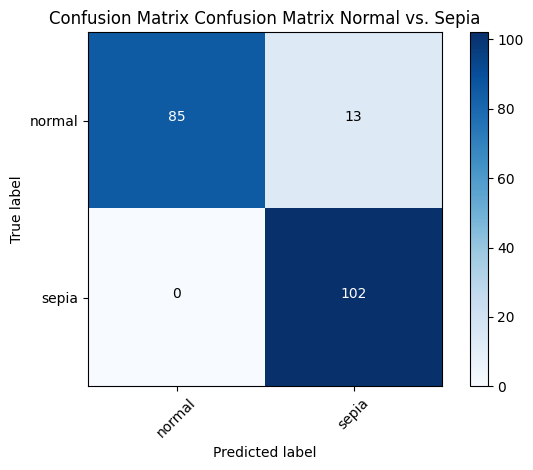

In [12]:
# obtinere model
model = get_ann(hidden_sizes=(128, 64), learning_rate=0.001, iter=100)
model.fit(train_inputs_norm, train_outputs)
predicted_labels = model.predict(test_inputs_norm)
real_labels = test_outputs

# evaluare performanta si afisare matrice de confuzie
acc, precision, recall, conf_matrix = eval_performance(real_labels, predicted_labels, output_names)
print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
plot_confusion_matrix(conf_matrix, output_names, title='Confusion Matrix Normal vs. Sepia')

## My ANN:

Iteration 1, loss: 0.7763576895897917
Iteration 2, loss: 0.6300438167829333
Iteration 3, loss: 0.6109681522461156
Iteration 4, loss: 0.60321404007316
Iteration 5, loss: 0.5972217707036301
Iteration 6, loss: 0.5917580024334214
Iteration 7, loss: 0.5865357368129663
Iteration 8, loss: 0.5814313914651864
Iteration 9, loss: 0.5763921569630103
Iteration 10, loss: 0.5714002145196924
Iteration 11, loss: 0.5664550584469112
Iteration 12, loss: 0.5615621039263241
Iteration 13, loss: 0.5567265969225217
Iteration 14, loss: 0.5519518140136183
Iteration 15, loss: 0.5472386783278964
Iteration 16, loss: 0.542585388893291
Iteration 17, loss: 0.5379875030224702
Iteration 18, loss: 0.5334387575771565
Iteration 19, loss: 0.5289321980873768
Iteration 20, loss: 0.52446114554031
Iteration 21, loss: 0.5200198450084806
Iteration 22, loss: 0.5156038426463114
Iteration 23, loss: 0.5112101672217285
Iteration 24, loss: 0.5068373481981905
Iteration 25, loss: 0.5024852553628321
Iteration 26, loss: 0.49815474770968726

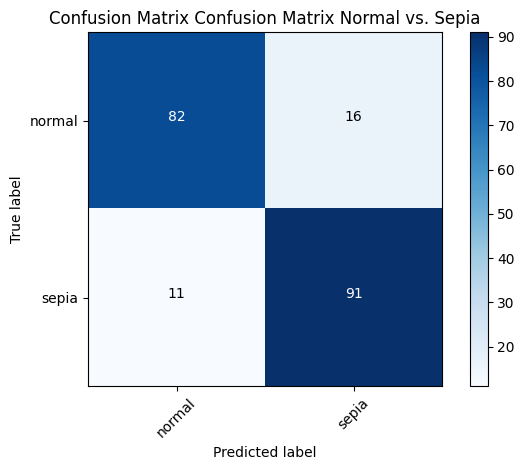

In [13]:
# obtinere model
model = get_ann(tool=False, hidden_sizes=(128, 64), learning_rate=0.001, iter=100)
model.fit(train_inputs_norm, train_outputs)
predicted_labels = model.predict(test_inputs_norm)
real_labels = test_outputs

# evaluare performanta si afisare matrice de confuzie
acc, precision, recall, conf_matrix = eval_performance(real_labels, predicted_labels, output_names)
print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
plot_confusion_matrix(conf_matrix, output_names, title='Confusion Matrix Normal vs. Sepia')

## My CNN:

Iteration 1, Loss: 0.414689
Iteration 2, Loss: 0.173537
Iteration 3, Loss: 0.107403
Iteration 4, Loss: 0.077347
Iteration 5, Loss: 0.064031
Iteration 6, Loss: 0.060376
Iteration 7, Loss: 0.049352
Iteration 8, Loss: 0.045641
Iteration 9, Loss: 0.041369
Iteration 10, Loss: 0.030094
Iteration 11, Loss: 0.026615
Iteration 12, Loss: 0.026547
Iteration 13, Loss: 0.019771
Iteration 14, Loss: 0.017427
Iteration 15, Loss: 0.015265
Accuracy: 0.995
Precision: {np.str_('normal'): np.float64(1.0), np.str_('sepia'): np.float64(0.9902912621359223)}
Recall: {np.str_('normal'): np.float64(0.9897959183673469), np.str_('sepia'): np.float64(1.0)}


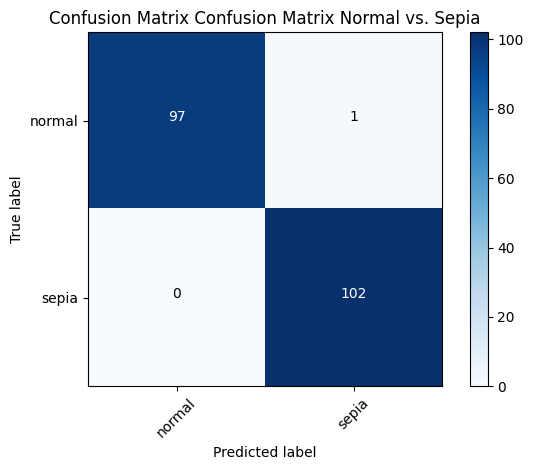

In [15]:
# normalizare date pentru cnn
train_inputs_norm_cnn, test_inputs_norm_cnn = normalisation_cnn(train_inputs, test_inputs)

# obtinere model
model = get_cnn(learning_rate=0.01, max_iter=15)
model.train(train_inputs_norm_cnn, train_outputs)
predicted_labels = model.predict(test_inputs_norm_cnn)
real_labels = test_outputs

# evaluare performanta si afisare matrice de confuzie
acc, precision, recall, conf_matrix = eval_performance(real_labels, predicted_labels, output_names)
print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
plot_confusion_matrix(conf_matrix, output_names, title='Confusion Matrix Normal vs. Sepia')